<h3> Loading and Preprocessing Data with TensorFlow </h3> 

- Data API
- Features API
- tf.Transform
- TF Datasets

<h3> Data API </h3> 

In [1]:
import tensorflow as tf

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset whose elements are all the slices of X. So this dataset contains 10 items. 

In [3]:
#repeat the dataset instance 3 times and get 7 items out of it 
dataset1 = dataset.repeat(3).batch(7)
for item in dataset1:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [4]:
dataset2 = dataset.repeat(3).batch(7, drop_remainder=True)
for item in dataset2:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)


dataset methods do not modify datasets. They only create new ones. Hence reference to the dataset is required

In [5]:
#applying transformations or functions to the data
dataset3 = dataset.map(lambda x: x*2)
for item in dataset3:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [6]:
dataset4 = dataset.filter(lambda x: x%2 == 0)
for item in dataset4:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


<h3> Shuffling the Data </h3> 

For effective shuffing, we can split a data source to multiple files, and then pick files randomly and simultaneously read them, interleaving their lines. 

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
housing = fetch_california_housing()
X_train_full,X_test,y_train_full,y_test = train_test_split(housing.data,housing.target.reshape(-1,1), random_state = 42)
X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full,random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

<h4> Splitting the data into many csv files </h4> 

In [9]:
#create dataframe of train,valid,test data
import pandas as pd
column_names = housing.feature_names + housing.target_names

housing_train_df = pd.DataFrame(data = X_train)
housing_train_df["Price"] = y_train
housing_train_df.columns = column_names

housing_valid_df = pd.DataFrame(data = X_valid)
housing_valid_df["Price"] = y_valid
housing_valid_df.columns = column_names

housing_test_df = pd.DataFrame(data = X_test)
housing_test_df["Price"] = y_test
housing_test_df.columns = column_names

In [10]:
dataframe_dict = {'train':housing_train_df, 'valid':housing_valid_df, 'test':housing_test_df}
n_parts = {'train':20, 'valid':10,'test':10}

In [11]:
import os
import numpy as np
file_path_dict = dict()
for key in dataframe_dict.keys():
    file_path_dict[key] = list()
    df = dataframe_dict[key]
    no_files = n_parts[key]
    dir_path = os.path.join(os.getcwd(),"housing",key)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    for file_idx,idx_array in enumerate(np.array_split(np.arange(df.shape[0]),no_files)):
        temp_df = df.iloc[idx_array,:]
        saving_path = os.path.join(dir_path,"{}_{}.csv".format(key,file_idx))
        file_path_dict[key].append(saving_path)
        temp_df.to_csv(saving_path, index = False)

In [12]:
#create list of filepaths for train, validate, test
train_filepaths = file_path_dict["train"]
valid_filepaths = file_path_dict["valid"]
test_filepaths = file_path_dict["test"]

By default the tf.data.Dataset.list_files() returns a dataset that shuffles the file paths

In [13]:
#create a dataset containing only the train filepaths
train_filepath_dataset = tf.data.Dataset.list_files(train_filepaths,seed = 42)
#next we can use the interleave() methods, with a number of files to read specified
n_readers = 5
dataset = train_filepath_dataset.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length = n_readers)
#the interleave method will create a dataset that will pull 5 file paths from the filepath_dataset and for each one, it calls the function we gave to create a new dataset. 
#After it runs through the first 5 filepaths, it will continue to run on the other filepaths

By default interleave() does not use parallelism. It reads one line at a time from each file, sequentially. 

In [14]:
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'3.9688,41.0,5.259786476868327,0.9715302491103203,916.0,3.2597864768683276,33.98,-118.07,1.698'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'
b'3.0217,22.0,4.983870967741935,1.1008064516129032,615.0,2.4798387096774195,38.76,-120.6,1.069'
b'3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442'


<h3> Preprocessing the data </h3> 

In [15]:
X_mean

array([ 3.89175860e+00,  2.86245478e+01,  5.45593655e+00,  1.09963474e+00,
        1.42428122e+03,  2.95886657e+00,  3.56464315e+01, -1.19584363e+02])

In [16]:
X_std

array([1.90927329e+00, 1.26409177e+01, 2.55038070e+00, 4.65460128e-01,
       1.09576000e+03, 2.36138048e+00, 2.13456672e+00, 2.00093304e+00])

In [17]:
n_inputs = 8

In [18]:
def preprocess(line):
    defs = [0.]*n_inputs + [tf.constant([],dtype = tf.float32)]
    #first argument is the line to pass
    #second is the default value in the column
    #by passing an empty array in tf.constant([]), we can accept any value into this, however it will raise exception if no value is available
    fields = tf.io.decode_csv(line,record_defaults=defs)
    #decode_csv returns a list of scalar tensors, which needs to be stacked to give a single 1D tensor
    x = tf.stack(fields[:-1])
    #stack allows us to stack the list of scalar tensors into one single 1D tensor
    y = tf.stack(fields[-1:])
    return (x - X_mean)/X_std, y

In [19]:
def csv_reader_dataset(filepaths,n_readers = 5, n_read_threads = None, shuffle_buffer_size = 10000, n_parse_threads = 5, batch_size = 32):
    dataset = tf.data.Dataset.list_files(filepaths)
    dataset = dataset.interleave(lambda filepath:tf.data.TextLineDataset(filepath), cycle_length = n_readers, num_parallel_calls = n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [20]:
Train_processed = csv_reader_dataset(train_filepaths, batch_size = 3)

In [21]:
#this takes 5 batches, with each batch having 3 training examples in it
for X_batch,y_batch in Train_processed.take(5):
    print("X =", X_batch)
    print("y =", y_batch)

X = tf.Tensor(
[[ 0.29893124  0.26702586 -0.03199343 -0.24048686  0.04628637 -0.15524797
  -0.9259175   0.83679074]
 [-0.71915257 -0.8404887   0.00444065  0.11843581 -0.63634485 -0.336742
  -0.752579    1.1266564 ]
 [ 0.09890732 -1.7897868   0.10207634 -0.15437837  0.0070442  -0.04980005
   0.3155529   0.15711132]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.535]
 [1.167]
 [1.102]], shape=(3, 1), dtype=float32)
X = tf.Tensor(
[[ 0.2858372  -1.4733541   0.22956713 -0.25643155 -0.23388447 -0.27743056
   1.63198    -0.73247695]
 [ 0.41976255 -1.9480032  -0.07677241  0.00292145  1.3367149  -0.31695908
   0.9901622  -1.1772691 ]
 [-1.1545014  -0.52405596 -0.45036566  0.17473558  1.0839224   0.4726118
   1.2150338  -1.2272451 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.851]
 [3.561]
 [0.875]], shape=(3, 1), dtype=float32)
X = tf.Tensor(
[[ 0.11901978  0.26702586 -0.31552222 -0.40635258 -0.08969231  0.48011157
  -0.752579    0.80680597]
 [ 5.818099    1.8491895   1.4826618  -0.07

In [22]:
Valid_processed = csv_reader_dataset(valid_filepaths)
Test_processed = csv_reader_dataset(test_filepaths)

Look into 
- concatenate()
- zip()
- window()
- reduce()
- cache()
- shard()
- flat_map()
- padded_batch()

<h3> TFRecord Format </h3> 

- TensorFlow's preferred format for storing large amounts of data
- Contains a sequence of binary records of varying sizes
- Each record has a length, a Cycle Redundancy Check checksum to check that the length was not corrupted. 

<h3> Protocol buffers </h3>

A portable, extensible and efficient binary format. 

In [23]:
a = b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [24]:
a

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [25]:
type(a)

bytes

In [26]:
a.decode('utf-8')

'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [27]:
import json 


test_json = {'one':{'a':'A','b':[1,2,3]},'two':{'c':'C','d':[1,2,3]}}

In [28]:
json_string = json.dumps(test_json)
type(json_string)

str

In [29]:
json.loads(json_string)

{'one': {'a': 'A', 'b': [1, 2, 3]}, 'two': {'c': 'C', 'd': [1, 2, 3]}}

<h3> The Features API </h3> 

It lets you define how each feature or group of features should be preprocessed. 

tf.feature_column

- Using bucketized_column to bin data

Sometimes you have multimodal data where there are separate peaks in it's distribution. In these cases, you define a bucket for each mode, where the boundaries are between the peaks.

https://www.tensorflow.org/tutorials/structured_data/feature_columns

In [30]:
petsdf = pd.read_csv(r'C:\Users\ASUS\Desktop\Hands on ML\Hands-on-Machine-Learning-Textbook-Exercises\DeepLearning_1\petfinder-mini\petfinder-mini.csv')
petsdf.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [31]:
petsdf['target'] = np.where(petsdf["AdoptionSpeed"] == 4,0,1)
petsdf.drop(columns=['AdoptionSpeed', 'Description'], inplace = True)
petsdf.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [32]:
train, test = train_test_split(petsdf, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

Wrap the dataset under tf.data as it allows us to use feature columns

In [33]:
def df_to_dataset(df,shuffle = True, batch_size = 32):
    df = df.copy()
    #obtain the targets
    labels = df.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [34]:
#getting the item thats required from a tensorflow dataset
#labels = train.pop('target')
#list(tf.data.Dataset.from_tensor_slices((dict(train),labels)).take(1).as_numpy_iterator())

In [35]:
train_ds = df_to_dataset(train,batch_size=5)
val_ds = df_to_dataset(val,shuffle = False, batch_size=5)
test_ds = df_to_dataset(test,shuffle = False, batch_size=5)

In [36]:
for feature_batch, label_batch in train_ds.take(1):
    print(list(feature_batch.keys()))
    print(feature_batch["Age"])
    print(label_batch)

['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
tf.Tensor([ 3  6  3  4 30], shape=(5,), dtype=int64)
tf.Tensor([1 1 1 1 1], shape=(5,), dtype=int32)


Using feature columns 

Now we create several types of feature columns and demonstrate how they transform a column from a dataframe

In [37]:
#iter creates a iterable of the input object
#then we can use next(iter(obj)) to obtain the element starting with the first one
example_batch = next(iter(train_ds))[0]

In [38]:
example_batch

{'Type': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Cat', b'Dog', b'Cat', b'Cat', b'Dog'], dtype=object)>,
 'Age': <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 7,  2, 12,  2, 36], dtype=int64)>,
 'Breed1': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Persian', b'Mixed Breed', b'Domestic Medium Hair',
        b'Domestic Short Hair', b'Rottweiler'], dtype=object)>,
 'Gender': <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'Female', b'Female', b'Female', b'Female', b'Female'],
       dtype=object)>,
 'Color1': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Golden', b'Brown', b'Black', b'Gray', b'Black'], dtype=object)>,
 'Color2': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Yellow', b'Cream', b'Brown', b'White', b'No Color'], dtype=object)>,
 'MaturitySize': <tf.Tensor: shape=(5,), dtype=string, numpy=array([b'Small', b'Medium', b'Medium', b'Medium', b'Large'], dtype=object)>,
 'FurLength': <tf.Tensor: shape=(5,), dtype=string, numpy=array([

Understanding of tf.keras.layers.DenseFeatures

By creating tf.feature_columns.xxx_column that does specific transformations, then adding these columns to a list, we create a list of transformations to be done on the data

feature_columns.append(transformation_name)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


Then we create a dictionary to associate column names with column values

inputs = {}

inputs("temp_num") = tf.keras.Input(shape = (1,), name = "feature_name")

#apply the transformation

x = feature_layer(inputs)

Continue normally 

x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)

https://stackoverflow.com/questions/54375298/how-to-use-tensorflow-feature-columns-as-input-to-a-keras-model

In [39]:
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [40]:
photo_count= tf.feature_column.numeric_column('PhotoAmt')

<h3> Bucketized columns </h3> 

In [41]:
age = tf.feature_column.numeric_column('Age')
age_bucketized = tf.feature_column.bucketized_column(age,boundaries = [1,3,5])

In [42]:
demo(age_bucketized)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [43]:
demo(age)

[[ 7.]
 [ 2.]
 [12.]
 [ 2.]
 [36.]]


<h3> Categorical columns </h3> 

We cannot feed strings directly into a model, hence we must first map them to numeric values. 

To pass in strings we can use:

- categorical_column_with_vocabulary_list
- categorical_column_with_vocabulary_file (if loading the categories from a list)

In [44]:
#converts into numerical values
animal_type = tf.feature_column.categorical_column_with_vocabulary_list('Type', ['Cat','Dog'])
#converts into one-hot vector
animal_type_one_hot = tf.feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


<h3> Embedding Columns </h3> 

If we have thousands or more values per category, as the number of categories grows large, it becomes infeasible to train a neural network using one-hot encodings. Embedding represents the data as a lower dimensional dense vector. 

In [45]:
breed1 = tf.feature_column.categorical_column_with_vocabulary_list('Breed1', train["Breed1"].unique().tolist())
breed1_embedding = tf.feature_column.embedding_column(breed1, dimension=5)
demo(breed1_embedding)

[[ 0.16019161  0.10407098 -0.17027213  0.12835957  0.71184766]
 [-0.32192352  0.28400755  0.03525333  0.6665355   0.30398765]
 [ 0.82431895 -0.3919796   0.19419418 -0.20051827 -0.16428047]
 [-0.27481022  0.36550444 -0.44418058  0.77817744 -0.7480454 ]
 [ 0.47958288 -0.0577272   0.32181862  0.50819725  0.25299302]]


<h3> Hashed Feature Columns </h3>

Calculates the hash value of a input, then selects the one of hash_bucket_size to encode the string. We can make the hash_bucket_size much smaller than the actual number of categories.

Key Point: An important downside of this technique is that there may be collisions in which different strings are mapped to the same bucket. In practice, this can work well for some datasets regardless.

In [46]:
breed1_hashed = tf.feature_column.categorical_column_with_hash_bucket("Breed1", hash_bucket_size = 10)
demo(tf.feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


<h3> Crossed feature columns </h3> 

Some features are better when combined, hence we may use this feature. 

It first creates the combinations for the 2 categories. Then makes hashes of the combinations. Then bucketize the hashes. 

How to implement feature columns

In [50]:
feature_columns = []
#remove target from features
attributes = train.columns.tolist()[:-1]
import re
numeric_columns = [value for value in attributes if re.match(r'int[0-9]*',str(train.dtypes.to_dict()[value])) != None]

#numeric columns
for header in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(header))

In [51]:
#bucketized_cols
age = tf.feature_column.numeric_column('Age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries = [1,2,3,4,5])
feature_columns.append(age_buckets)

In [52]:
indicator_columns = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize','FurLength', 'Vaccinated', 'Sterilized', 'Health']

for header in indicator_columns:
    categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(header, petsdf[header].unique().tolist())
    feature_columns.append(tf.feature_column.indicator_column(categorical_column))

In [53]:
#embedding columns
breed1 = tf.feature_column.categorical_column_with_vocabulary_list('Breed1',petsdf["Breed1"].unique().tolist())
breed1_embedding = tf.feature_column.embedding_column(breed1, dimension = 8)
feature_columns.append(breed1_embedding)

In [54]:
age_type_feature = tf.feature_column.crossed_column([age_buckets,animal_type], hash_bucket_size = 100)
feature_columns.append(tf.feature_column.indicator_column(age_type_feature))

Now that we have defined all out column transformations using the Feature API, we can create a DenseFeatures layer to input to Keras model

In [55]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [56]:
#earlier we only used 5 instances per batch. Now we use 32
train_ds = df_to_dataset(train,batch_size=32)
val_ds = df_to_dataset(val,shuffle = False, batch_size=32)
test_ds = df_to_dataset(test,shuffle = False, batch_size=32)

In [57]:
model = tf.keras.models.Sequential()
model.add(feature_layer)
model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dense(128,activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=20, verbose=2)

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
231/231 - 9s - loss: 3.8861 - accuracy: 0.6572 - val_loss: 0.2016 - val_accuracy: 0.7384
Epoch 2/20
231/231 - 1s - loss: 1.1677 - accuracy: 0.6840 - val_loss: 0.2449 - val_accuracy: 0.7134
Epoch 3/20
231/231 - 1s - loss: 0.4553 - accuracy: 0.7106 - val_loss: 0.1686 - val_accuracy: 0.7638
Epoch 4/20
231/231 - 2s - loss: 0.2232 - accuracy: 0.7376 - val_loss: 0.1728 - val_accuracy: 0.7470
Epoch 5/20
231/231 - 2s - loss: 0.1950 - accuracy: 0.7374 - val_loss: 0.1670 - val_accuracy: 0.7703
Epoch 6/20
231/231 - 2s - loss: 0.1777 - accuracy: 0.7437 - val_loss: 0.1619 - val_accuracy: 0.7687
Epoch 7/20
231/231 - 2s - loss: 0.1760 - accuracy: 0.7471 - val_loss: 0.1606 - val_accuracy: 0.7725
Epoch 8/20
231/231 - 2s - loss: 0.1681 - accuracy: 0.7535 - val_loss: 0.1620 - val_accuracy: 0.7709
Epoch 9/20
231/231 - 2s - loss: 0.1

In [58]:
model.get_weights()

[array([[ 0.6905893 ,  0.23404378, -0.5467346 , ...,  0.0378064 ,
          0.28499797,  0.16461433],
        [ 0.02444424,  0.4081142 , -0.16803841, ..., -0.17349735,
          0.05701346,  0.2367723 ],
        [ 0.28152987, -0.21735023, -0.4710192 , ..., -0.16805528,
          0.76712924, -0.03458797],
        ...,
        [-0.19362989, -0.30251452, -0.12716497, ...,  0.4502629 ,
          0.5728758 , -0.23505493],
        [-0.06567337,  0.14846231,  0.37099352, ...,  0.150354  ,
         -0.42210668,  0.1090459 ],
        [ 0.5860604 ,  0.1521738 ,  0.27636138, ...,  0.16178508,
         -0.50957954, -0.16023323]], dtype=float32),
 array([[-0.18134637,  0.08602463,  0.09490586, ...,  0.00997966,
          0.04246956, -0.12157874],
        [ 0.17611948,  0.09984765,  0.21516244, ...,  0.10849623,
         -0.07664641, -0.0863409 ],
        [-0.00813522, -0.03928092, -0.0810244 , ..., -0.20598674,
          0.17744046, -0.13046768],
        ...,
        [-0.27452695, -0.11763006,  0.0

<h3> More on encoding categorical features using one hot vectors </h3> 

No matter which option you choose to build a categorical feature (categorical, bucketized or crossed columns), it must be encoded before feeding into the neural network. 

A one-hot vector encoding has the size of the vocabulary length, which is fine if there are only few categories. 

But if the vocabulary is large, it ends up with too many inputs resulting in too many weights to learn. 

As a rule of thumb, if the number of categories is lower than 10, then one-hot encoding is generally the way to go. If the number of categories is greater than 50, we use embedding. 

<h3> Encoding using embeddings </h3> 

Embedding is a trainable dense vector that represents a category.

An embedding will group words with similar meanings based on the training text and return their location.

With embedding we can convert seemingly "senseless" data such as ID to useful features. 

The rule of thumb is to typicakky reduce the features y the 4th root of the total number of categories. 

In [59]:
df_cat = petsdf.loc[petsdf["Type"] == "Cat"]
unique_cat_breed_pairs = set(tuple(zip(df_cat["Type"],df_cat["Breed1"])))
unique_cat_breed_pairs

{('Cat', 'Abyssinian'),
 ('Cat', 'American Curl'),
 ('Cat', 'American Shorthair'),
 ('Cat', 'American Wirehair'),
 ('Cat', 'Applehead Siamese'),
 ('Cat', 'Australian Kelpie'),
 ('Cat', 'Balinese'),
 ('Cat', 'Belgian Shepherd Laekenois'),
 ('Cat', 'Bengal'),
 ('Cat', 'Birman'),
 ('Cat', 'Bobtail'),
 ('Cat', 'Bombay'),
 ('Cat', 'British Shorthair'),
 ('Cat', 'Burmese'),
 ('Cat', 'Burmilla'),
 ('Cat', 'Calico'),
 ('Cat', 'Chartreux'),
 ('Cat', 'Chausie'),
 ('Cat', 'Collie'),
 ('Cat', 'Cymric'),
 ('Cat', 'Dilute Calico'),
 ('Cat', 'Dilute Tortoiseshell'),
 ('Cat', 'Domestic Long Hair'),
 ('Cat', 'Domestic Medium Hair'),
 ('Cat', 'Domestic Short Hair'),
 ('Cat', 'Egyptian Mau'),
 ('Cat', 'Exotic Shorthair'),
 ('Cat', 'Extra-Toes Cat (Hemingway Polydactyl)'),
 ('Cat', 'Havana'),
 ('Cat', 'Himalayan'),
 ('Cat', 'Japanese Bobtail'),
 ('Cat', 'Javanese'),
 ('Cat', 'Korat'),
 ('Cat', 'Maine Coon'),
 ('Cat', 'Manx'),
 ('Cat', 'Mixed Breed'),
 ('Cat', 'Nebelung'),
 ('Cat', 'Norwegian Forest Cat'),

In [60]:
df_dog = petsdf.loc[petsdf["Type"] == "Dog"]
unique_dog_breed_pairs = set(tuple(zip(df_dog["Type"],df_dog["Breed1"])))
unique_dog_breed_pairs

{('Dog', '0'),
 ('Dog', 'Akita'),
 ('Dog', 'American Bulldog'),
 ('Dog', 'American Staffordshire Terrier'),
 ('Dog', 'American Water Spaniel'),
 ('Dog', 'Australian Kelpie'),
 ('Dog', 'Australian Shepherd'),
 ('Dog', 'Australian Terrier'),
 ('Dog', 'Basenji'),
 ('Dog', 'Basset Hound'),
 ('Dog', 'Beagle'),
 ('Dog', 'Bedlington Terrier'),
 ('Dog', 'Belgian Shepherd Dog Sheepdog'),
 ('Dog', 'Belgian Shepherd Laekenois'),
 ('Dog', 'Belgian Shepherd Malinois'),
 ('Dog', 'Black Labrador Retriever'),
 ('Dog', 'Black Mouth Cur'),
 ('Dog', 'Border Collie'),
 ('Dog', 'Boston Terrier'),
 ('Dog', 'Boxer'),
 ('Dog', 'Bull Terrier'),
 ('Dog', 'Bullmastiff'),
 ('Dog', 'Cattle Dog'),
 ('Dog', 'Cavalier King Charles Spaniel'),
 ('Dog', 'Chihuahua'),
 ('Dog', 'Chinese Crested Dog'),
 ('Dog', 'Chow Chow'),
 ('Dog', 'Cocker Spaniel'),
 ('Dog', 'Collie'),
 ('Dog', 'Coonhound'),
 ('Dog', 'Corgi'),
 ('Dog', 'Dachshund'),
 ('Dog', 'Dalmatian'),
 ('Dog', 'Doberman Pinscher'),
 ('Dog', 'Dutch Shepherd'),
 ('Dog

In [61]:
combined_type_category = ["{}_{}".format(val[0],val[1]) for typelist in [unique_cat_breed_pairs,unique_dog_breed_pairs] for val in typelist]



In [62]:
combined_type_category

['Cat_Siberian',
 'Cat_Cymric',
 'Cat_Terrier',
 'Cat_Collie',
 'Cat_Australian Kelpie',
 'Cat_Abyssinian',
 'Cat_Birman',
 'Cat_Snowshoe',
 'Cat_Torbie',
 'Cat_American Curl',
 'Cat_Tuxedo',
 'Cat_Bengal',
 'Cat_Maine Coon',
 'Cat_Norwegian Forest Cat',
 'Cat_Silver',
 'Cat_Chausie',
 'Cat_Nebelung',
 'Cat_Javanese',
 'Cat_Dilute Tortoiseshell',
 'Cat_Siamese',
 'Cat_Burmese',
 'Cat_Oriental Long Hair',
 'Cat_Ragdoll',
 'Cat_Domestic Medium Hair',
 'Cat_Tortoiseshell',
 'Cat_Manx',
 'Cat_Turkish Angora',
 'Cat_Belgian Shepherd Laekenois',
 'Cat_Himalayan',
 'Cat_Oriental Tabby',
 'Cat_Domestic Short Hair',
 'Cat_Singapura',
 'Cat_Mixed Breed',
 'Cat_Korat',
 'Cat_Havana',
 'Cat_Burmilla',
 'Cat_Ocicat',
 'Cat_Japanese Bobtail',
 'Cat_Extra-Toes Cat (Hemingway Polydactyl)',
 'Cat_Calico',
 'Cat_Ragamuffin',
 'Cat_American Shorthair',
 'Cat_Turkish Van',
 'Cat_British Shorthair',
 'Cat_Chartreux',
 'Cat_Egyptian Mau',
 'Cat_Russian Blue',
 'Cat_Shih Tzu',
 'Cat_Oriental Short Hair',
 'C

In [63]:
type_breed_combo = tf.feature_column.categorical_column_with_vocabulary_list("type_breed_combo",combined_type_category)
embedded_type_breed = tf.feature_column.embedding_column(type_breed_combo,dimension = 2)

In [64]:
embedded_type_breed

EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='type_breed_combo', vocabulary_list=('Cat_Siberian', 'Cat_Cymric', 'Cat_Terrier', 'Cat_Collie', 'Cat_Australian Kelpie', 'Cat_Abyssinian', 'Cat_Birman', 'Cat_Snowshoe', 'Cat_Torbie', 'Cat_American Curl', 'Cat_Tuxedo', 'Cat_Bengal', 'Cat_Maine Coon', 'Cat_Norwegian Forest Cat', 'Cat_Silver', 'Cat_Chausie', 'Cat_Nebelung', 'Cat_Javanese', 'Cat_Dilute Tortoiseshell', 'Cat_Siamese', 'Cat_Burmese', 'Cat_Oriental Long Hair', 'Cat_Ragdoll', 'Cat_Domestic Medium Hair', 'Cat_Tortoiseshell', 'Cat_Manx', 'Cat_Turkish Angora', 'Cat_Belgian Shepherd Laekenois', 'Cat_Himalayan', 'Cat_Oriental Tabby', 'Cat_Domestic Short Hair', 'Cat_Singapura', 'Cat_Mixed Breed', 'Cat_Korat', 'Cat_Havana', 'Cat_Burmilla', 'Cat_Ocicat', 'Cat_Japanese Bobtail', 'Cat_Extra-Toes Cat (Hemingway Polydactyl)', 'Cat_Calico', 'Cat_Ragamuffin', 'Cat_American Shorthair', 'Cat_Turkish Van', 'Cat_British Shorthair', 'Cat_Chartreux', 'Cat_Egyptian Mau', 'Cat_Ru

In [65]:
dense_layer_test = tf.keras.layers.DenseFeatures([embedded_type_breed])

In [66]:
result = dense_layer_test({
    "type_breed_combo":combined_type_category
    }).numpy()

In [67]:
vector_label_combined_type_breed = tuple(zip(combined_type_category,result))
vector_label_combined_type_breed

(('Cat_Siberian', array([ 0.4174289, -0.0595459], dtype=float32)),
 ('Cat_Cymric', array([-0.09757801, -0.6830158 ], dtype=float32)),
 ('Cat_Terrier', array([0.43987358, 0.76479065], dtype=float32)),
 ('Cat_Collie', array([0.5995611 , 0.13188113], dtype=float32)),
 ('Cat_Australian Kelpie', array([-0.3047965 ,  0.34143513], dtype=float32)),
 ('Cat_Abyssinian', array([-0.6000862 , -0.41544506], dtype=float32)),
 ('Cat_Birman', array([ 1.0018126 , -0.37282228], dtype=float32)),
 ('Cat_Snowshoe', array([-0.98878485, -0.60708994], dtype=float32)),
 ('Cat_Torbie', array([0.5137909, 0.9470142], dtype=float32)),
 ('Cat_American Curl', array([-0.73888886,  1.0841365 ], dtype=float32)),
 ('Cat_Tuxedo', array([-0.480495  ,  0.02985689], dtype=float32)),
 ('Cat_Bengal', array([ 0.38475174, -1.1092777 ], dtype=float32)),
 ('Cat_Maine Coon', array([-0.7450547 ,  0.77990896], dtype=float32)),
 ('Cat_Norwegian Forest Cat', array([-1.2197012, -0.5436412], dtype=float32)),
 ('Cat_Silver', array([ 0.876

In [68]:
dog_label_vector = vector_label_combined_type_breed[-10:]
cat_label_vector = vector_label_combined_type_breed[:10]

In [69]:
cat_label_vector[0][1][0]
cat_label = [x[0] for x in cat_label_vector]
cat_x = [x[1][0] for x in cat_label_vector]
cat_y = [x[1][1] for x in cat_label_vector]

In [70]:
dog_label_vector[0][1][0]
dog_label = [x[0] for x in dog_label_vector]
dog_x = [x[1][0] for x in dog_label_vector]
dog_y = [x[1][1] for x in dog_label_vector]

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

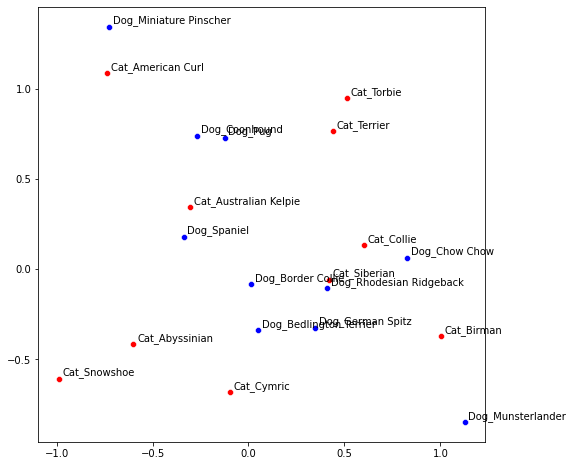

In [72]:
fig,ax = plt.subplots(1,1,figsize = (8,8))
sns.scatterplot(x = cat_x, y = cat_y, color = 'red', ax = ax)
for x,y,label in zip(cat_x,cat_y,cat_label):
    ax.text(x + 0.02, y + 0.02, label)

sns.scatterplot(x = dog_x, y = dog_y, color = 'blue', ax = ax)
for x,y,label in zip(dog_x,dog_y,dog_label):
    ax.text(x + 0.02, y + 0.02, label)

<h3>TensorFlow Datasets</h3> 

In [73]:
import tensorflow_datasets as tfds

In [74]:
dataset = tfds.load(name = "mnist")
mnist_train,mnist_test = dataset["train"],dataset["test"]

mnist_train = mnist_train.repeat(5).batch(32)

In [75]:
for item in mnist_train:
    print(item['image'])
    print(item['label'])
    break

tf.Tensor(
[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
  

In [76]:
mnist_train

<BatchDataset shapes: {image: (None, 28, 28, 1), label: (None,)}, types: {image: tf.uint8, label: tf.int64}>